<a href="https://colab.research.google.com/github/slvDev/Malaria-Detection-CNN-Keras/blob/master/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Initial step**

Basic initial step import required libraries


*   os - for handling paths
*   cv2 - best lib for image processing
*   zipfile - obviously work with zip archives
*   tensorflow - self-explanatory
*   randrange - we will use for selecting random images




In [0]:
%matplotlib inline
import os
import cv2
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from random import randrange

This for connecting google drive fo colab. 
For some reason uploading to colab virtual machine very slow, so more efficient to upload data ones to google drive and simply connect it. 

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization. And mount it in preferred path.
drive.mount('/content/drive')

In [0]:
zip_ref_train = zipfile.ZipFile('/content/drive/My Drive/cell-images-for-detecting-malaria.zip', 'r')
zip_ref_train.extractall('/content')
zip_ref_train.close()

In [0]:
ROOT_DATA_DIR = '/content/cell_images'
INF_DIR = os.path.join(ROOT_DATA_DIR, 'Parasitized')
UNINF_DIR = os.path.join(ROOT_DATA_DIR, 'Uninfected')

inf_fnames = os.listdir(INF_DIR)
uninf_fnames = os.listdir(UNINF_DIR)

print(f'Amount of parasitized images: {len(inf_fnames)}')
print(f'Amount of uninfected images: {len(uninf_fnames)}')
print(f'Total Images: {len(inf_fnames) + len(uninf_fnames)}')

Amount of parasitized images: 13780
Amount of uninfected images: 13780
Total Images: 27560


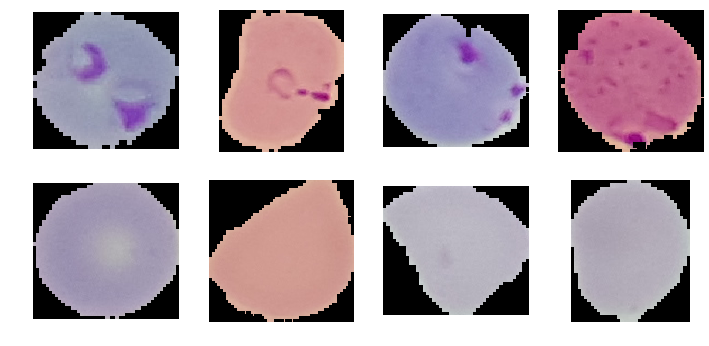

In [0]:
nrows, ncols = 4, 4
fig_size = 3 

fig = plt.gcf()
fig.set_size_inches(ncols * fig_size, nrows * fig_size)

inf_pic_paths = [os.path.join(INF_DIR, inf_fnames[randrange(len(inf_fnames))]) 
                for _ in range(4) 
                ]

uninf_pic_paths = [os.path.join(UNINF_DIR, uninf_fnames[randrange(len(uninf_fnames))]) 
                for _ in range(4) 
                ]

for i, img_path in enumerate(inf_pic_paths + uninf_pic_paths):  
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [0]:
def split_data(sourse, split_size):
    #Create root folder for valid&test data
    root_folder_name = ROOT_DATA_DIR.strip('/').split('/')[-1]
    valid_test_folder = ROOT_DATA_DIR.replace(root_folder_name,
                                            'valid_test_' + root_folder_name)
    
    os.mkdir(valid_test_folder)
    
    folders = os.listdir(sourse)
    for folder in folders:
        os.mkdir(os.path.join(valid_test_folder, folder))
        fnames = os.listdir(os.path.join(sourse, folder))
        start_split = len(fnames) - int(len(fnames) * split_size)
        splited_fnames = fnames[start_split:]
        for fname in splited_fnames:
            s_dir = os.path.join(sourse, folder, fname)
            d_dir = os.path.join(valid_test_folder, folder, fname)
            move(s_dir, d_dir)
        print(f'Moved {len(splited_fnames)} files')


In [0]:
split_data(ROOT_DATA_DIR, 0.2)

Moved 2756 files
Moved 2756 files


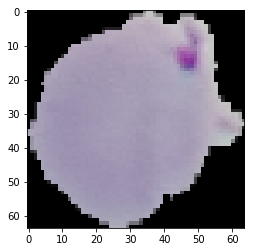

In [0]:
img_size = 64
dim = img_size, img_size

img_path = os.path.join(INF_DIR, inf_fnames[1])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, dim)

plt.imshow(img)
plt.show()

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        shear_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        )

train_generator = train_datagen.flow_from_directory(
        '/content/cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        )

Found 22046 images belonging to 2 classes.


In [0]:
valid_test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.5
        )

valid_generator = valid_test_datagen.flow_from_directory(
        '/content/valid_test_cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        subset='training',
        )

test_generator = valid_test_datagen.flow_from_directory(
        '/content/valid_test_cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        subset='validation',
        )

Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
__________

In [0]:
history = model.fit_generator(
        train_generator,
        epochs=40,
        validation_data=valid_generator,
        )

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
689/689 [==============================] - 64s 93ms/step - loss: 0.4063 - acc: 0.8364 - val_loss: 0.1963 - val_acc: 0.9329
Epoch 2/40
689/689 [==============================] - 62s 89ms/step - loss: 0.1796 - acc: 0.9385 - val_loss: 0.1499 - val_acc: 0.9492
Epoch 3/40
689/689 [==============================] - 62s 89ms/step - loss: 0.1623 - acc: 0.9446 - val_loss: 0.1730 - val_acc: 0.9289
Epoch 4/40
689/689 [==============================] - 61s 88ms/step - loss: 0.1593 - acc: 0.9466 - val_loss: 0.1419 - val_acc: 0.9514
Epoch 5/40
689/689 [==============================] - 59s 86ms/step - loss: 0.1601 - acc: 0.9459 - val_loss: 0.1969 - val_acc: 0.9321
Epoch 6/40
689/689 [==============================] - 59s 86ms/step - loss: 0.1532 - acc: 0.9490 - val_loss: 0.1320 - val_acc: 0.9561
Epoch 7/40
689/689 [==============================] - 59s 86ms/step - loss: 0.1474 - acc: 0.9506 - val_loss: 0.1277 - val_acc: 0.9550
Epoch 8/40
689

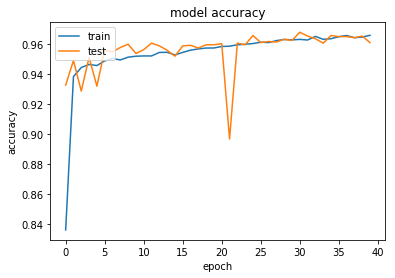

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

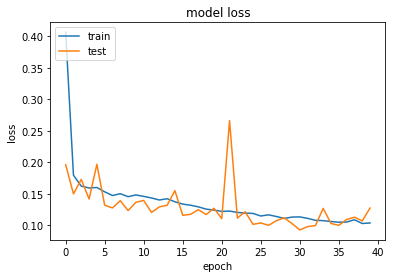

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.evaluate_generator(test_generator, verbose=1)

87/87 [==============================] - 3s 34ms/step - loss: 0.1081 - acc: 0.9655


[0.10810593013576734, 0.96552974]